In [1]:
from keras.layers import Input, Dense, Embedding, LSTM, Dropout, concatenate
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
import numpy as np
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
#ツイートのテキスト読み込み
test = open("extract_tweet.txt", "r", encoding="utf-8")
lines = test.readlines()
test.close()
print(len(lines))

#ラベル読み込み
test = open("label.txt", "r", encoding="utf-8")
label = test.readlines()
test.close()
print(len(label))

10000
10000


In [3]:
#userID
test = open("user.txt","r", encoding="utf-8")
uID = test.readlines()
test.close()
print(len(uID))

10000


In [4]:
id_list = []
for i in uID:
    if i in id_list:
        continue
    else:
        id_list.append(i)

In [5]:
print(len(id_list))

32


In [6]:
post_user = []
for i in uID:
    for j in range(len(id_list)):
        if i == id_list[j]:
            post_user.append(j)

In [7]:
n_postUser = np.array(post_user)

In [8]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
from keras.utils.np_utils import to_categorical

maxlen = 50
training_samples = 7000 # training data 80 : validation data 20
validation_samples = 1000
test_samples = len(lines) - (training_samples + validation_samples)
max_words = 20000

# word indexを作成
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(lines)
sequences = tokenizer.texts_to_sequences(lines)

word_index = tokenizer.word_index
print("Found {} unique tokens.".format(len(word_index)))

data = pad_sequences(sequences, maxlen=maxlen)

# バイナリの行列に変換
categorical_labels = to_categorical(label)
labels = np.asarray(categorical_labels)

print("Shape of data tensor:{}".format(data.shape))
print("Shape of label tensor:{}".format(labels.shape))

#学習データとテストデータに分割
#data = data[:training_samples + validation_samples]
#labels = labels[:training_samples + validation_samples]
#n_postUser = n_postUser[:training_samples + validation_samples]


# 行列をランダムにシャッフルする
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
users = n_postUser[indices]

x1_train = data[:training_samples]
x2_train = users[:training_samples]
y_train = labels[:training_samples]
x1_val = data[training_samples: training_samples + validation_samples]
x2_val = users[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]
x1_test = data[training_samples + validation_samples: training_samples + validation_samples +test_samples]
x2_test = users[training_samples + validation_samples: training_samples + validation_samples +test_samples]
y_test = labels[training_samples + validation_samples: training_samples + validation_samples +test_samples]

Found 18881 unique tokens.
Shape of data tensor:(10000, 50)
Shape of label tensor:(10000, 2)


In [9]:
print(x1_test)

[[    0     0     0 ...  1901  1337  5594]
 [    0     0     0 ...  3162    36   676]
 [    0     0     0 ...  2340   328  1270]
 ...
 [    0     0     0 ...     1     7     8]
 [    0     0     0 ...   113    31   872]
 [    0     0     0 ... 10208    15    63]]


In [10]:
import keras.backend as K
from functools import partial

def normalize_y_pred(y_pred):
    return K.one_hot(K.argmax(y_pred), y_pred.shape[-1])

def class_true_positive(class_label, y_true, y_pred):
    y_pred = normalize_y_pred(y_pred)
    return K.cast(K.equal(y_true[:, class_label] + y_pred[:, class_label], 2), K.floatx())

def class_accuracy(class_label, y_true, y_pred):
    y_pred = normalize_y_pred(y_pred)
    return K.cast(K.equal(y_true[:, class_label], y_pred[:, class_label]),
                  K.floatx())

def class_precision(class_label, y_true, y_pred):
    y_pred = normalize_y_pred(y_pred)
    return K.sum(class_true_positive(class_label, y_true, y_pred)) / (K.sum(y_pred[:, class_label]) + K.epsilon())


def class_recall(class_label, y_true, y_pred):
    return K.sum(class_true_positive(class_label, y_true, y_pred)) / (K.sum(y_true[:, class_label]) + K.epsilon())


def class_f_measure(class_label, y_true, y_pred):
    precision = class_precision(class_label, y_true, y_pred)
    recall = class_recall(class_label, y_true, y_pred)
    return (2 * precision * recall) / (precision + recall + K.epsilon())


def true_positive(y_true, y_pred):
    y_pred = normalize_y_pred(y_pred)
    return K.cast(K.equal(y_true + y_pred, 2),
                  K.floatx())


def micro_precision(y_true, y_pred):
    y_pred = normalize_y_pred(y_pred)
    return K.sum(true_positive(y_true, y_pred)) / (K.sum(y_pred) + K.epsilon())


def micro_recall(y_true, y_pred):
    return K.sum(true_positive(y_true, y_pred)) / (K.sum(y_true) + K.epsilon())


def micro_f_measure(y_true, y_pred):
    precision = micro_precision(y_true, y_pred)
    recall = micro_recall(y_true, y_pred)
    return (2 * precision * recall) / (precision + recall + K.epsilon())


def average_accuracy(y_true, y_pred):
    class_count = y_pred.shape[-1]
    class_acc_list = [class_accuracy(i, y_true, y_pred) for i in range(class_count)]
    class_acc_matrix = K.concatenate(class_acc_list, axis=0)
    return K.mean(class_acc_matrix, axis=0)


def macro_precision(y_true, y_pred):
    class_count = y_pred.shape[-1]
    return K.sum([class_precision(i, y_true, y_pred) for i in range(class_count)]) / K.cast(class_count, K.floatx())


def macro_recall(y_true, y_pred):
    class_count = y_pred.shape[-1]
    return K.sum([class_recall(i, y_true, y_pred) for i in range(class_count)]) / K.cast(class_count, K.floatx())


def macro_f_measure(y_true, y_pred):
    precision = macro_precision(y_true, y_pred)
    recall = macro_recall(y_true, y_pred)
    return (2 * precision * recall) / (precision + recall + K.epsilon())

In [11]:
p_input = Input(shape=(50, ), dtype='int32', name='input_postText')
u_input = Input(shape=(1, ), dtype='int32', name='input_userID')


#em = Embedding(input_dim=20000, output_dim=1024, input_length=50)(p_input)
#shered_lstm = LSTM(32)
#p_lstm = shered_lstm(em)
#u_lstm = shered_lstm(u_input)

x = concatenate([p_input, u_input])
em = Embedding(input_dim=20000, output_dim=50, input_length=51)(x)
d_em = Dropout(0.5)(em)
lstm_out = LSTM(32)(d_em)
d_lstm_out = Dropout(0.5)(lstm_out)
output = Dense(2, activation='softmax', name = 'output')(d_lstm_out)

model = Model(inputs=[p_input, u_input], outputs = output)
model.compile(optimizer='Adam', loss='categorical_crossentropy',  metrics=['acc', macro_precision, macro_recall, macro_f_measure])
model.summary()
#plot_model(model, show_shapes=True, show_layer_names=True, to_file='MultiParameter_model.png')


early_stopping = EarlyStopping(patience=0, verbose=1)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_postText (InputLayer)     (None, 50)           0                                            
__________________________________________________________________________________________________
input_userID (InputLayer)       (None, 1)            0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 51)           0           input_postText[0][0]             
                                                                 input_userID[0][0]               
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 51, 50)       1000000     concatenate_1[0][0]              
__________

In [12]:
history = model.fit([x1_train, x2_train], y_train,
                    epochs=100, 
                    batch_size=100,
                    validation_data=([x1_val, x2_val], y_val),
                    callbacks=[early_stopping])

Train on 7000 samples, validate on 1000 samples
Epoch 1/100
7000/7000 [==============================] - 8s 1ms/step - loss: 0.6224 - acc: 0.6851 - macro_precision: 0.6927 - macro_recall: 0.6869 - macro_f_measure: 0.6897 - val_loss: 0.4912 - val_acc: 0.7820 - val_macro_precision: 0.7836 - val_macro_recall: 0.7817 - val_macro_f_measure: 0.7826
Epoch 2/100
7000/7000 [==============================] - 6s 870us/step - loss: 0.3955 - acc: 0.8366 - macro_precision: 0.8407 - macro_recall: 0.8356 - macro_f_measure: 0.8381 - val_loss: 0.4291 - val_acc: 0.8050 - val_macro_precision: 0.8066 - val_macro_recall: 0.8034 - val_macro_f_measure: 0.8050
Epoch 3/100
7000/7000 [==============================] - 6s 831us/step - loss: 0.2859 - acc: 0.8889 - macro_precision: 0.8904 - macro_recall: 0.8889 - macro_f_measure: 0.8896 - val_loss: 0.4623 - val_acc: 0.8060 - val_macro_precision: 0.8103 - val_macro_recall: 0.8056 - val_macro_f_measure: 0.8079
Epoch 00003: early stopping


In [13]:
loss_and_metrics = model.evaluate([x1_test, x2_test], y_test)
print(loss_and_metrics)

2000/2000 [==============================] - 2s 892us/step
[0.46183041751384735, 0.8075, 0.8125885381698609, 0.8074180045127869, 0.8098577871322632]


In [13]:
classes = model.predict([x1_test, x2_test])
np.savetxt('Mult_predict.csv', classes, delimiter = ',')

In [14]:
model.metrics_names

['loss', 'acc', 'macro_precision', 'macro_recall', 'macro_f_measure']

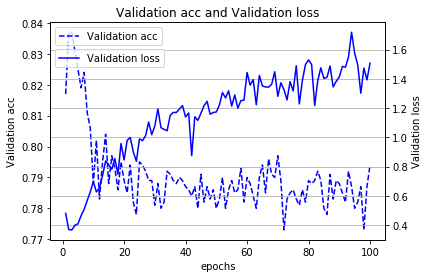

In [12]:
import matplotlib.pyplot as plt

val_acc = history.history['val_acc']
val_loss = history.history['val_loss']
epochs = range(1, len(val_acc) + 1)

fig = plt.figure()
ax_acc = fig.add_subplot(111)
ax_acc.plot(epochs, val_acc, 'b--', label='Validation acc')
plt.legend(bbox_to_anchor=(0, 1), loc='upper left', borderaxespad=0.5, fontsize=10)

ax_loss = ax_acc.twinx()
ax_loss.plot(epochs, val_loss, 'b', label='Validation loss')
plt.legend(bbox_to_anchor=(0, 0.9), loc='upper left', borderaxespad=0.5, fontsize=10)
plt.title('Validation acc and Validation loss')
ax_acc.set_xlabel('epochs')
ax_acc.set_ylabel('Validation acc')
ax_loss.grid(True)
ax_loss.set_ylabel('Validation loss')

plt.show()